In [1]:
import xarray as xr

# Generate cutouts with `DataArray.rolling`

In [2]:
# open raster data as DataArray
bands = xr.open_rasterio("S2_composite_2019-11-1_2020-3-1_tile_1.tif")
bands

<xarray.DataArray (band: 4, y: 12502, x: 12505)>
[625350040 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 -3.75e+05 -3.75e+05 -3.75e+05 ... -5e+05 -5e+05 -5e+05
  * x        (x) float64 -2e+06 -2e+06 -2e+06 ... -1.875e+06 -1.875e+06
Attributes:
    transform:      (10.0, 0.0, -2000050.0, 0.0, -10.0, -375000.0)
    crs:            +init=epsg:3031
    res:            (10.0, 10.0)
    is_tiled:       1
    nodatavals:     (nan, nan, nan, nan)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    descriptions:   ('B4_first', 'B3_first', 'B2_first', 'B11_first')
    AREA_OR_POINT:  Area

In [3]:
# initialize rolling object 
rolling = bands.rolling(
    x=20,
    y=20,
)
rolling

DataArrayRolling [x->20,y->20]

In [4]:
%%time
cutouts = rolling.construct(
    {'x':'x_win', 'y': 'y_win'}, 
    stride={'x': 15, 'y': 15},
)

CPU times: user 9.89 s, sys: 2.01 s, total: 11.9 s
Wall time: 11.9 s


In [5]:
# get size (in GB) of original array and of cutouts  
bands.nbytes/2**30, cutouts.nbytes/2**30

(1.164805218577385, 4.14583683013916)

In [6]:
cutouts.shape  # bands, x, y, x_win, y_win

(4, 834, 834, 20, 20)

In [7]:
%%time
# create combined dimension from x and y ("sample")
cutouts = cutouts.stack(sample=["x", "y"])

CPU times: user 12.8 s, sys: 2.27 s, total: 15 s
Wall time: 15.7 s


In [9]:
cutouts.shape # bands, x_win, y_win, sample

(4, 20, 20, 695556)

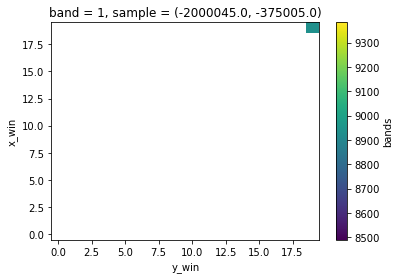

In [10]:
# issue: cutouts along the edge of the original raster are filled with NaN's
cutouts.attrs["long_name"] = "bands"
cutouts.isel(band=0, sample=0).plot.imshow()

In [11]:
%%time
# drop all NaN-containing cutouts - also useful if array has been masked with coastline shape
cutouts = cutouts.dropna(dim="sample", how="any")

CPU times: user 11.2 s, sys: 7.01 s, total: 18.2 s
Wall time: 21.1 s


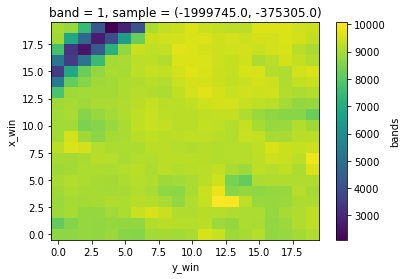

In [12]:
cutouts.isel(band=0, sample=0).plot.imshow()

In [13]:
cutouts.shape # bands, x_win, y_win, sample

(4, 20, 20, 692224)

In [14]:
# final array size (in GB)
cutouts.nbytes / 2**30

4.1259765625